In the previous section, we learned all about plotting with matplotlib using the `pyplot` interface. And, in the last two lessons of this section, we took a deeper look at the architecture of matplotlib, and the components that make up a typical plot. In this lesson, we'll go even deeper, and put what we've learned to the test by tracing the steps that a call to a plotting function in `pyplot` goes through "behind the scenes". 

Now, before we can get started, we have a little bit of setup that we need to do for everything to be as clear as possible, so let's go ahead and jump right in and get started.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

## Setup

One of the differences between this lesson and the previous ones, is that in this lesson, we want to be in complete control over when our plots are rendered, so our first step will be to turn off interactive mode.

In [2]:
# Turn off interactive mode, so we have full control
# over when our plots are displayed.
plt.ioff()

Rather than displaying our plots inline, in this lesson, for reasons we'll cover later, we'll be saving each figure to a file instead. To do so, we'll need a folder in which to save our plots, and the bash code below creates that directory for us. 

One thing I'd like to point out here is that the directory the code below creates will reside within the `/tmp` directory. If you are on a Windows machine, or if you don't have the right permissions to modify the `/tmp` directory, you'll want to change the `tmpdir` variable on line 3 below.

In [3]:
%%bash --out tmpdir

tmpdir="/tmp/mpl"
if [ -d "$tmpdir" ]
then 
    rm -rf "$tmpdir"
fi
mkdir "$tmpdir"

echo -n "$tmpdir"

## Helper Functions

In the next few cells we'll be creating a few helper functions that we'll use throughout the rest of this lesson. Now, if you don't have a ton of experience with python, you may be looking at the code below and thinking to yourself "What do you mean functions? All I see are a handful of classes!" Well, you're right, at least partially. 

You'll notice in each of the classes below we've implemented this weird looking method (`__call__`) with leading and trailing underscores which is called, by most pythonistas at least, "dunder call". This method allows instances of a class to be called just like a function, and doing so will actually call this special method. The really nice thing about this feature is that these callable objects have state that can change, as well as change the behavior of the function, with each call. This is nice, because it allows us to setup some variables that are used, and altered, by the function without making those variables global.

For example, the first class below, `FilenameGenerator`, takes two variables when it's created: a base directory, which will be the temp directory we created in the last step, and a filename extension. It will then use these two variables, along with a third, to generate a filename every time it's called. That third variable is where the real magic happens. Now, we want a unique filename every time we call this function, and we want the names to be sortable, so we can later display them in the same order in which they were created. To do that, we have this third variable, called `fignum`, which will be incremented every time we call our function. If we were to try and do this without a callable object, we would have to either create `fignum` as a global variable, or use a closure to prevent the variable from leaking into the global space. The global variable approach is just bad practice for so many reasons, and personally, I feel that callable objects are actually easier to understand than closures, and bit cleaner as well. 

In [4]:
class FilenameGenerator(object):
    """A generator for creating unique filenames.
    """
    def __init__(self, basedir, ext):
        self.basedir = basedir
        self.ext = ext
        self.fignum = 0
    def __call__(self):
        self.fignum += 1
        return '%s/fig_%02d.%s' % (self.basedir, self.fignum, self.ext)
generate_filename = FilenameGenerator(tmpdir, 'png')

The next helper function, or callable object, is a simple print function that takes a message and prints it with a leading line number. To do this, we'll need a variable that keeps track of the current line number, and that's the reason that we've gone with a callable object here instead of a simple function.

In [5]:
class PrintlnFunc(object):
    def __init__(self):
        self.line = 1
    def __call__(self, msg):
        print "%2d. %s" % (self.line, msg)
        self.line += 1
    def reset(self):
        self.line = 1
println = PrintlnFunc()

Finally, the callable object below is a decorator that adds some simple logging to a function. When called, it will print out a bit of information on the function it's decorating before and after calling it. We'll use this callable object to decorate several functions in the matplotlib library so we can trace the set of function calls that are made each time we call a function from the `pyplot` interface. The reason we're using a callable object here instead of a function, is because we need a variable to keep track of the depth of the call stack, so we can make our logging information more readable.

In [6]:
class Logger(object):
    """Wraps a function in a callable that prints call information
    """
    level = 0

    def __init__(self, fn):
        self.fn = fn

    def __call__(self, *args, **kwargs):
        # Create the padding string according to the current level in the call
        # stack, and increase the level since we're about to pop another 
        # function onto the stack.
        padding = "|" + "-" * (Logger.level * 4 - 1) if Logger.level > 0 else ""
        Logger.level += 1

        # Print calling information, call the function, and print returning info
        println("%sCalling %s.%s" % (padding, self.fn.__module__, self.fn.__name__))
        result = self.fn(*args, **kwargs)
        println("%sReturning <%s:%s> from %s.%s" % \
            (padding, result.__class__.__name__, id(result), self.fn.__module__, self.fn.__name__))

        # Decrease the call stack level, since we are returning.
        Logger.level -= 1
        return result

## Exploring the `pyplot` Call Stack

So, now that we have a bunch of helper functions setup and ready to be used, we're ready to start exploring how `pyplot` works. First, we'll use the `Logger` class that we created in the last cell to decorate several functions on the `pyplot` module.

In [7]:
# Decorate several methods with the logger
plt.gca = Logger(plt.gca)
plt.gcf = Logger(plt.gcf)
plt.figure = Logger(plt.figure)
plt.close = Logger(plt.close)

We also want to decorate a few methods on the `Figure` and `Axes` classes, especially the `__init__` functions so we can see when a new instance of each is being created, but decorating a function attached to a class is a bit different from decorating a regular function. To make this possible, we'll have to use the `types.MethodType` class to wrap our `Logger` object. Other than that, the code below is pretty identical to the last bit.

In [8]:
# To decorate the methods on the Figure class, we have to wrap 
# our logger in a MethodType instance.
import types

# Logging the calls for which the pyplot functions are simple
# proxies. Specifically, the add_subplot and __init__ methods
# are interesting because the allow us to see when new objects
# are being created.
from matplotlib.figure import Figure
from matplotlib.axes import Axes
Figure.gca = types.MethodType(Logger(Figure.gca), None, Figure)
Figure.add_subplot = types.MethodType(Logger(Figure.add_subplot), None, Figure)
Figure.__init__ = types.MethodType(Logger(Figure.__init__), None, Figure)
Axes.__init__ = types.MethodType(Logger(Axes.__init__), None, Axes)

So, now we have everything setup to make it possible to trace all the work that the `pyplot` interface is doing on our behalf whenever we call a simple plotting function. The only thing left to do is to actually try and plot something.

In [9]:
plt.hist(np.random.randn(1000));

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |-------Calling matplotlib.pyplot.figure
 4. |-----------Calling matplotlib.figure.__init__
 5. |-----------Returning <NoneType:4296531008> from matplotlib.figure.__init__
 6. |-------Returning <Figure:4397008464> from matplotlib.pyplot.figure
 7. |---Returning <Figure:4397008464> from matplotlib.pyplot.gcf
 8. |---Calling matplotlib.figure.gca
 9. |-------Calling matplotlib.figure.add_subplot
10. |-----------Calling matplotlib.axes._base.__init__
11. |-----------Returning <NoneType:4296531008> from matplotlib.axes._base.__init__
12. |-------Returning <AxesSubplot:4397045456> from matplotlib.figure.add_subplot
13. |---Returning <AxesSubplot:4397045456> from matplotlib.figure.gca
14. Returning <AxesSubplot:4397045456> from matplotlib.pyplot.gca


What we see happening above, and in the diagram below, is that the `pyplot.hist()` function first tries to get the current `Axes` object by calling the `pyplot.gca()` function---remember I mentioned in the last lesson that the `Axes` class was the main interface for plotting. Then, to get the current axes, the `pyplot.gca()` function must first get the current `Figure` by calling the `pyplot.gcf()` function---remember that the `Figure` object is the root object that contains all of the components in a plot, or collection of plots. Then, the `pyplot.gcf()` function will check for the top most figure on a stack of figures. If one exists, it will return it, otherwise, it will call the `pyplot.figure()` function which will create an instance of the `Figure` class and add it to the stack. Then, the `pyplot.gcf()` function will return the newly created figure. After getting the current figure, the `pyplot.gca()` function will check if the figure contains an axes object, and if it doesn't it will call the `Figure.add_subplot()` function to create one. Finally, after the `pyplot.gca()` function returns the newly created `Axes` object, the `pyplot.hist()` function will call the `Axes.hist()` function on it to create our histogram.

<img src="../images/pyplot_stateful_interface.jpeg" />

Now, we're not going to show the histogram that we've just created here, because the interactive backends (i.e., the UI backends and the Jupyter notebook) automatically destroy the figure object after it is shown. Since we want to see how the `pyplot` interface works both with, and without, a current figure, we'll save our histogram to the disk instead to keep the current figure object on the stack. The call below will save the figure to the temp directory we created at the begining of this lesson using the `generate_filename()` callable object we made to create a unique, sortable filename.

<!--- the _pylab_helpers.destroy function is called once the figure is shown. So, we end up with only 1 active figure in the queue at all times. However, when rendering a hardcopy the figure is not destroyed, and so calling any plot command will simply add to the current figure. There are two ways to prevent this from happening: first, you can call the plt.clf() function to clear the current figure before you reuse it, second, you can call the plt.figure() function to create a new figure. We'll go with first option here and save the call to plt.figure() for our next lesson --->

In [10]:
plt.savefig(generate_filename())

15. Calling matplotlib.pyplot.gcf
16. Returning <Figure:4397008464> from matplotlib.pyplot.gcf


You probably noticed that calling the `pyplot.savefig()` function caused the `pyplot.gcf()` function to be called. By having a stateful interface that keeps track of the current figure being used, the `pyplot` module has saved us a few keystokes by allowing us to save a figure without explicitly defining which figure to save. And, if you want to see the figure stack itself, you can simply call the `pyplot.get_fignums()` to get a list of the figures in the stack.

In [12]:
plt.get_fignums()

[1]

## Where's the State

If you're curious as to where the state in `pyplot`'s stateful interface resides, you can find it in the `_pylab_helpers` module. In this module, you'll find a singleton class called `Gcf` that contains a list of `Figure` objects called the `Gcf._activeQue`. To see what's in the stack, we'll create a function that will loop through each figure in the stack and print out each one's figure number and `id`.

In [14]:
from matplotlib import _pylab_helpers

def print_fig_stack():
    for figmgr in _pylab_helpers.Gcf._activeQue:
        print "(%d, <Figure:%d>)" % (figmgr.num, id(figmgr.canvas.figure))

print_fig_stack()

(1, <Figure:4397008464>)


Again, we can two things using this function: first, we have exactly one figure in the current stack, and second, that figure is the one that created with our very first call to the `pyplot.hist()` function (you can tell by looking at the `id`'s).

Of course, there's one problem with reusing a figure: calling anymore plot commands will simply add to the current figure, which isn't what we want at all. Now, there are two ways to prevent this from happening: first, you can call the `plt.clf()` function to clear the current figure before you reuse it, and second, you can call the `plt.figure()` function to create a brand new figure. We'll go with first option here and save the call to `plt.figure()` for discussion in our next lesson. 

In [15]:
plt.clf()

 1. Calling matplotlib.pyplot.gcf
 2. Returning <Figure:4397008464> from matplotlib.pyplot.gcf


And, now we're going to create another plot to see how the `pyplot` interface acts when we already have an existing `Figure` object. But first, before we do that, we want to start the line numbering over, and luckily we can do that with a call to the `println.reset()` function. Finally, we use our `generate_filename()` function again to save our new figure to the temp directory with the next consecutive filename.

In [16]:
println.reset()
plt.plot(np.random.randn(100))
plt.savefig(generate_filename())

 1. Calling matplotlib.pyplot.gca
 2. |---Calling matplotlib.pyplot.gcf
 3. |---Returning <Figure:4397008464> from matplotlib.pyplot.gcf
 4. |---Calling matplotlib.figure.gca
 5. |-------Calling matplotlib.figure.add_subplot
 6. |-----------Calling matplotlib.axes._base.__init__
 7. |-----------Returning <NoneType:4296531008> from matplotlib.axes._base.__init__
 8. |-------Returning <AxesSubplot:4400052944> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4400052944> from matplotlib.figure.gca
10. Returning <AxesSubplot:4400052944> from matplotlib.pyplot.gca
11. Calling matplotlib.pyplot.gcf
12. Returning <Figure:4397008464> from matplotlib.pyplot.gcf


This time around, you'll notice that there are slightly fewer calls. Again, the `pyplot.gca()` and `pyplot.gcf()` functions are called, but this time around, there is already a figure present on the stack, so the `pyplot.figure()` function is never called to create a new `Figure` object. Outside of that, everything looks nearly identical to the `pyplot.hist()` call. Also, notice that the `id` for the figure used in the code above is the same one as the figure used in the histogram sample, and since we're once again saving the figure instead of showing it, this `id` should also match that of the figure in the current figure stack and we can prove it by once again calling our `print_fig_stack()`.

In [19]:
print_fig_stack()

(1, <Figure:4397008464>)


Just to show that everything else worked as you'd expect, we're displaying each of the figure images that we created earlier with the code below.

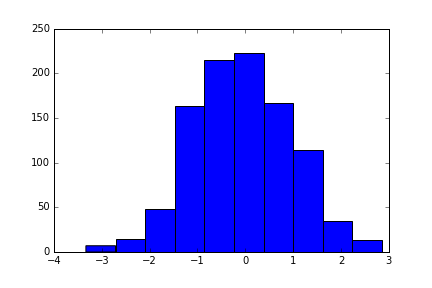

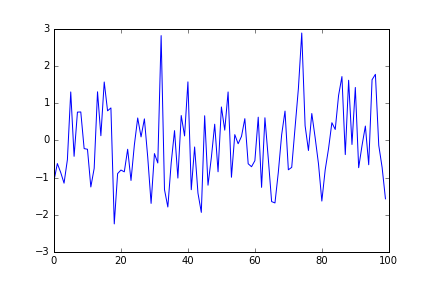

In [20]:
from IPython.display import Image, display_png
images = !ls /tmp/mpl/*.png
for img_fname in images:
    display_png(Image(filename=img_fname))

## Conclusion

